In [1]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython import display
import imageio
import glob

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
# load_data
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
# normalize data
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

4423680/4422102 [==============================] - 0s 0us/step


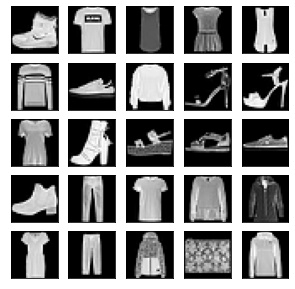

In [3]:
# visualize
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap='gray')
plt.show()

In [4]:
# batch and shuffle the training data
x_train = x_train.reshape(-1, 28, 28, 1) *2. -1.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [5]:
# generator network
num_features = 100
generator = keras.models.Sequential([
                                     keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
                                     keras.layers.Reshape([7,7,128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64,(5,5),(2,2), padding='same', activation='selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1,(5,5),(2,2), padding='same', activation='tanh'),
                                     ])

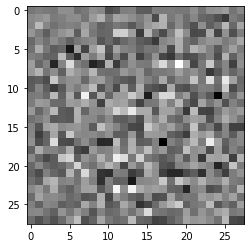

In [6]:
# test generator
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
# discriminator network
discriminator= keras.models.Sequential([
                                        keras.layers.Conv2D(64,(5,5),(2,2), padding='same', input_shape=[28,28,1]),
                                        keras.layers.LeakyReLU(0.2),
                                        keras.layers.Dropout(0.3),
                                        keras.layers.Conv2D(128,(5,5),(2,2), padding='same'),
                                        keras.layers.LeakyReLU(0.2),
                                        keras.layers.Dropout(0.3),
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
# test discriminator
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50426024]], shape=(1, 1), dtype=float32)


In [9]:
# compile
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [10]:
# training loop
seed = tf.random.normal(shape=[batch_size, 100])
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  # use the gan model to get the generator and descriminator
  generator, discriminator = gan.layers
  # iterate through the num of epochs
  for epoch in tqdm(range(epochs)):
    print('epochs {}/{}'.format(epoch+1, epochs))
    # iterate through batches of training data
    for X_batch in dataset:
      # train the generator to create batches of fake images
      # create random vector of gausian distributed noise
      noise = tf.random.normal(shape=[batch_size, num_features])
      # pass the random noise to the generator
      generated_image = generator(noise)
      # create dataset of both real and fake images
      X_fake_and_real = tf.concat([generated_image, X_batch], axis=0)
      # define class labels. reals->1 fake->0
      y1= tf.constant([[0,]] * batch_size + [[1,]]* batch_size)
      discriminator.trainable = True
      # train discriminator
      discriminator.train_on_batch(X_fake_and_real, y1)
      # Mark every images as real
      y2 = tf.constant([[1,]]*batch_size)
      discriminator.trainable = False
      # train gan
      gan.train_on_batch(noise, y2)
    # clear previous output
    display.clear_output(wait=True)
    # saving the network output for particular seed
    generate_and_save_images(generator, epoch +1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epoch+1, seed)

In [11]:
# https://www.tensorflow.org/tutorials/generative/dcgan
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

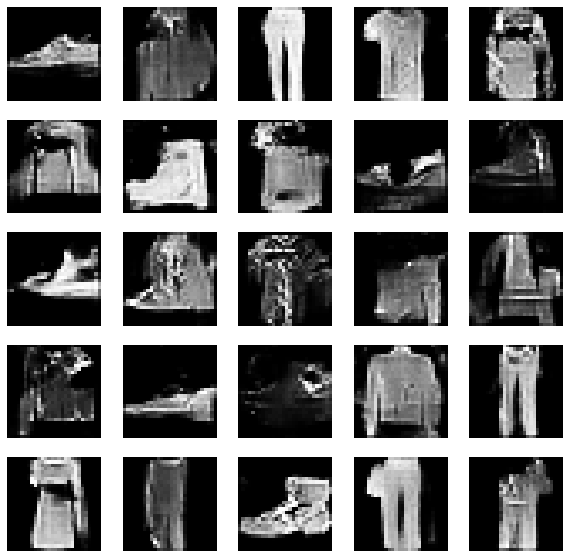

CPU times: user 2min 46s, sys: 9.29 s, total: 2min 55s
Wall time: 2min 51s


In [12]:
# train dcgan
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=5)

In [13]:
# https://www.tensorflow.org/tutorials/generative/dcgan
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>